# Streamflow Data Download and Preprocessing

Metadata for streamflow to be downloaded from: https://wateroffice.ec.gc.ca/station_metadata/station_characteristics_e.html using the specifications `Province = Alberta`, `Parameter Type = Flows`, and `Regulation = Natural` and saved as `station_metadata.csv`.

The stations listed in the metadata file subject to the date specifications are downloaded below from HYDAT and saved to `combined_streamflow.csv`.

In [ ]:
import urllib.parse
import pandas as pd

batch_size = 50

# define start and end years
start_year = 1980
end_year = 2022

metadata = pd.read_csv("station_metadata.csv")

def build_wateroffice_url(stations, start_date, end_date, parameter="flow"):
    """
    Build a Wateroffice batch-download URL for daily data.
    
    Parameters
    ----------
    stations : list of str
        List of hydrometric station numbers (e.g. ["11AB104", "11AB105"]).
    start_date : str
        Start date in YYYY-MM-DD.
    end_date : str
        End date in YYYY-MM-DD.
    parameter : str
        Usually "flow" for discharge.
    
    Returns
    -------
    str
        A full URL that can be used to download a combined CSV of all stations.
    """

    base = "https://wateroffice.ec.gc.ca/services/daily_data/csv/inline?"

    # Encode station parameters properly
    # stations[]=11AB104&stations[]=11AB105&...
    station_params = "&".join([f"stations[]={urllib.parse.quote(s)}" for s in stations])

    # Encode parameter (e.g. flow)
    param_part = f"parameters[]={urllib.parse.quote(parameter)}"

    # Add date range
    date_part = f"start_date={start_date}&end_date={end_date}"

    url = base + station_params + "&" + param_part + "&" + date_part
    return url

def download_wateroffice_data(stations, start_date, end_date, parameter="flow"):
    url = build_wateroffice_url(stations, start_date, end_date, parameter)
    return pd.read_csv(url)

# filter the stations based on given year range
filtered_metadata = metadata[(metadata['Year From'] <= start_year) & (metadata['Year To'] >= end_year)]
study_stations = filtered_metadata["Station Number"].tolist()

all_data = []

for i in range(0, len(study_stations), batch_size):
    batch_stations = study_stations[i:i + batch_size]
    
    df_batch = download_wateroffice_data(
        batch_stations,
        start_date=f"{start_year}-01-01",
        end_date=f"{end_year}-12-31"
    )

    all_data.append(df_batch[[" ID", "Date", "Value/Valeur"]])

# Combine all files into a single long-format DataFrame
df_long = pd.concat(all_data, ignore_index=True)

# Convert Date to datetime to ensure proper sorting
df_long["Date"] = pd.to_datetime(df_long["Date"])

# Pivot into wide format: rows = dates, columns = station IDs
df_wide = df_long.pivot(index="Date", columns=" ID", values="Value/Valeur")

# Sort rows (by Date) and columns (station IDs)
df_wide = df_wide.sort_index().sort_index(axis=1)

df_wide.to_csv("combined_streamflow.csv")

print("Data downloaded and saved to combined_streamflow.csv")
print(f"{df_wide.shape[0]} days of data saved for {df_wide.shape[1]} stations")

Data downloaded and saved to combined_streamflow.csv
15706 days of data saved for 179 stations


### Perform imputation on the remaining stations using the following steps:
#### Station omission:
1. Remove stations with >40% total missing data
2. Remove stations with any calendar year having >40% missing data
#### Missing data imputation:
1. Interpolate any gaps in data less than 7 consecutive days
2. Fill remaining missing days with the mean daily flow for that day-of-year across all years provided there is more than 3 years of data for that day-of-year
3. Days that have no data for that day-of-year across all years will be filled with the minimum flow recorded at that station for that year

In [7]:
import pandas as pd

# maximum acceptable missing data percentage
missing_data_pct = 0.4

# ----------------------------------------------------------
# 1. Load data
# ----------------------------------------------------------
df = pd.read_csv("combined_streamflow.csv", parse_dates=["Date"])
df = df.set_index("Date")

stations = df.columns

# A place to store reports
removed_total_missing = []
removed_year_missing = []

# ----------------------------------------------------------
# 2. Remove stations with >60% total missing data
# ----------------------------------------------------------
total_missing_frac = df.isna().mean()

step1_keep = total_missing_frac[total_missing_frac <= missing_data_pct].index
step1_removed = total_missing_frac[total_missing_frac > missing_data_pct].index.tolist()

removed_total_missing = step1_removed
df_step1 = df[step1_keep].copy()

# ----------------------------------------------------------
# 3. Remove stations with >60% missing in any given year
# ----------------------------------------------------------
df_step1["Year"] = df_step1.index.year

step2_keep = []
step2_removed = []

for st in step1_keep:
    yearly_missing = df_step1[st].groupby(df_step1["Year"]).apply(lambda x: x.isna().mean())

    if (yearly_missing > missing_data_pct).any():
        step2_removed.append(st)
    else:
        step2_keep.append(st)

removed_year_missing = step2_removed
df_step2 = df_step1[step2_keep]

# ----------------------------------------------------------
# 4. Fill missing data for remaining stations
# ----------------------------------------------------------
df_filled = df_step2.copy()

# ---- Step 4.1 Interpolate short gaps (<7 days) ----
df_filled = df_filled.interpolate(method="time", limit=6)

# Pre-calculate Day of Year
doy = df_filled.index.dayofyear

# ---- Step 4.2 Daily climatology mean for DOY (≥3 valid years) ----
for st in df_filled.columns:
    series = df_filled[st]

    # Build climatology: mean across years, count years with data
    clim_mean = series.groupby(doy).mean()
    clim_count = series.groupby(doy).count()

    missing_idx = series[series.isna()].index

    for t in missing_idx:
        d = t.dayofyear

        # Only use climatology if ≥3 years of valid data
        if clim_count[d] >= 3:
            df_filled.loc[t, st] = clim_mean[d]

# ---- Step 4.3 Fill remaining (seasonal stations) with the minimum value for that year ----
for st in df_filled.columns:
    series = df_filled[st]
    
    # Compute minimum for each year
    yearly_min = series.groupby(series.index.year).min()
    
    # Fill remaining missing values
    for t in series[series.isna()].index:
        yr = t.year
        fill_val = yearly_min.loc[yr]
        df_filled.loc[t, st] = fill_val

# ----------------------------------------------------------
# 5. Save reports + cleaned data
# ----------------------------------------------------------
# pd.DataFrame({"Removed_Total_Missing": removed_total_missing}).to_csv("removed_step1_total_missing.csv", index=False)
# pd.DataFrame({"Removed_Year_Missing": removed_year_missing}).to_csv("removed_step2_year_missing.csv", index=False)

df_filled.to_csv("combined_streamflow_cleaned.csv")

print("Insufficient total data:", removed_total_missing)
print("Insufficient annual data:", removed_year_missing)
print("Final number of stations:", len(df_filled.columns))
print("Imputation complete.")


Insufficient total data: ['05AA011', '05AA027', '05BA001', '05BH013', '05BL012', '05BL027', '05CA004', '05CA012', '05CD004', '05CE012', '05DA002', '05DC011', '05DD004', '05DD007', '05EA002', '05FA012', '07AA007', '07AC001', '07AF003', '07BA001', '07BA003', '07BH003', '07DB002', '07DB003', '07DD001', '07DD003', '07FD908']
Insufficient annual data: ['05AA030', '05AB013', '05AC030', '05CA011', '05CC008', '05CC009', '05CE002', '05CE020', '05DF003', '05DF004', '05DF006', '05EA001', '05EB902', '05EC002', '05FA014', '05GA008', '06AA002', '06AC001', '07AG003', '07BA002', '07BB011', '07BC006', '07BE003', '07BK001', '07CA003', '07CA005', '07CA008', '07CD004', '07DA006', '07FD009', '07FD012', '07GB001', '07GE001', '07JD004', '11AA032']
Final number of stations: 118
Imputation complete.


### Visualization of imputed values against raw data for verification

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# ----------------------------
# Load raw and cleaned data
# ----------------------------
raw = pd.read_csv("combined_streamflow.csv", parse_dates=[0], index_col=0)
clean = pd.read_csv("combined_streamflow_cleaned.csv", parse_dates=[0], index_col=0)

# Ensure same ordering
raw = raw[clean.columns]

# ----------------------------
# Identify imputed values
# ----------------------------
# Boolean mask: True where cleaned value != raw value (or raw was NaN)
imputed_mask = clean.ne(raw) | raw.isna()

# ----------------------------
# Plot settings
# ----------------------------
stations = list(clean.columns)
batch_size = 10
num_batches = math.ceil(len(stations) / batch_size)

for b in range(num_batches):
    batch_stations = stations[b*batch_size : (b+1)*batch_size]

    fig, axes = plt.subplots(
        nrows=10, ncols=1, figsize=(18, 30), sharex=True
    )
    fig.suptitle(f"Streamflow Raw vs Imputed — Stations {b*batch_size+1} to {(b+1)*batch_size}",
                 fontsize=18)

    if len(batch_stations) < 10:
        axes = axes[:len(batch_stations)]

    for ax, st in zip(axes, batch_stations):
        series_clean = clean[st]
        series_raw = raw[st]

        # Plot raw values
        ax.plot(series_raw.index, series_raw, label="Raw", linewidth=1)
        q_std = series_raw.std()
        ax.set_ylim(
            bottom=0,
            top=series_raw.mean() + q_std
        )

        # Plot imputed values
        imputed_idx = imputed_mask[st]
        ax.scatter(
            series_clean.index[imputed_idx],
            series_clean[imputed_idx],
            s=2,
            c="red",
            label="Imputed",
        )

        ax.set_title(st, loc="left", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


### Visualize the glaciation percentages of the basins

Stations in timeseries: 111
Stations after inner join: 111


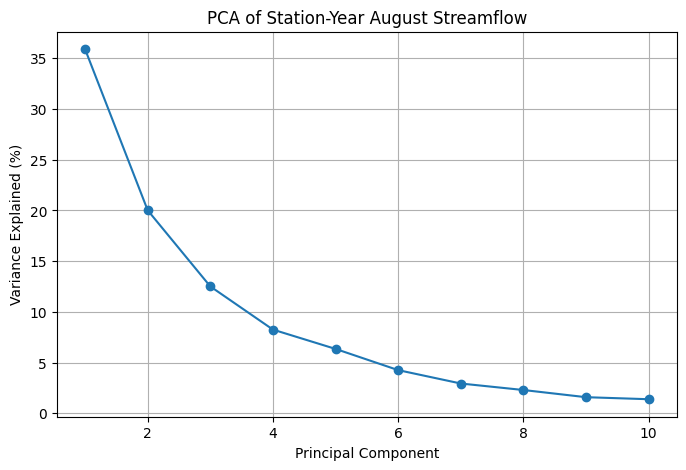

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
flow = pd.read_csv("combined_streamflow_cleaned.csv", parse_dates=[0], index_col=0)
meta = pd.read_csv("basin_glaciation_pct_data.csv", dtype=str)

# Parse lat/lon and glaciation percentage
meta = meta[["StationNum", "pct_glacia", "station__3", "station__4", "Area_km2"]]
meta["pct_glacia"] = pd.to_numeric(meta["pct_glacia"].replace("", "0"), errors="coerce").fillna(0.0)
meta["lat"] = pd.to_numeric(meta["station__3"], errors="coerce")
meta["lon"] = pd.to_numeric(meta["station__4"], errors="coerce")
meta.drop(columns=["station__3", "station__4"], inplace=True)

# Inner join stations
stations_common = flow.columns.intersection(meta["StationNum"])
flow = flow[stations_common]
meta = meta[meta["StationNum"].isin(stations_common)].set_index("StationNum").loc[stations_common]

print(f"Stations in timeseries: {flow.shape[1]}")
print(f"Stations after inner join: {meta.shape[0]}")

# -------------------------------------------------
# Build samples: one vector per station per year
# -------------------------------------------------
flow["year"] = flow.index.year
flow["DOY"] = flow.index.dayofyear

samples = []
labels = []  # keep track of station/year

days = range(1, 366)  # include leap day if present

for st in stations_common:
    for yr, group in flow.groupby("year"):
        series = group[st]

        smoothed = series.rolling(window=30, center=True, min_periods=1).mean()

        # Build DOY vector
        climatology = smoothed.groupby(group["DOY"]).mean()
        vect = climatology.reindex(days).values

        samples.append(vect)
        labels.append((st, yr))

X = np.array(samples)

# -------------------------------------------------
# Standardize each sample (row-wise)
# -------------------------------------------------
X_scaled = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

# include only August (day 213 to 244)
# X_scaled = X_scaled[:, 152-1:244-1]

# -------------------------------------------------
# PCA
# -------------------------------------------------
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
expl_var = pca.explained_variance_ratio_

# -------------------------------------------------
# Plot variance explained per mode
# -------------------------------------------------
plt.figure(figsize=(8, 5))
# plt.plot(np.arange(1, len(expl_var)+1), expl_var*100, marker="o")
plt.plot(np.arange(1, 11), expl_var[:10]*100, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("PCA of Station-Year August Streamflow")
plt.grid(True)
plt.show()

In [2]:
# kaiser's rule method to select number of components
num_components = np.sum(pca.explained_variance_ > 1.0)
print(f"Number of components selected (Kaiser's rule): {num_components}")

Number of components selected (Kaiser's rule): 13


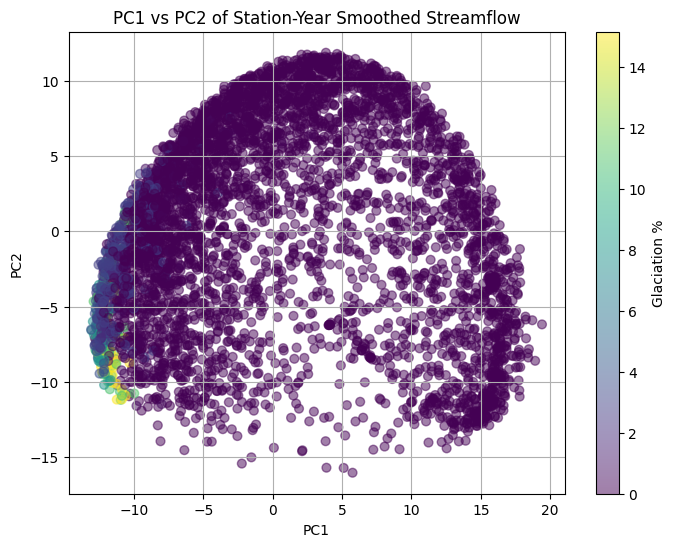

In [5]:
# -------------------------------------------------
# Project data into PCA space
# -------------------------------------------------
X_pca = pca.transform(X_scaled)

# First two principal components
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# -------------------------------------------------
# Plot PC1 vs PC2
# -------------------------------------------------
plt.figure(figsize=(8, 6))

# Example: color by glaciation percentage
colors = meta.loc[[st for st, yr in labels], "pct_glacia"]

scatter = plt.scatter(pc1, pc2, c=colors, cmap="viridis", s=40, alpha=0.5)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 of Station-Year Smoothed Streamflow")

cbar = plt.colorbar(scatter)
cbar.set_label("Glaciation %")

plt.grid(True)
plt.show()

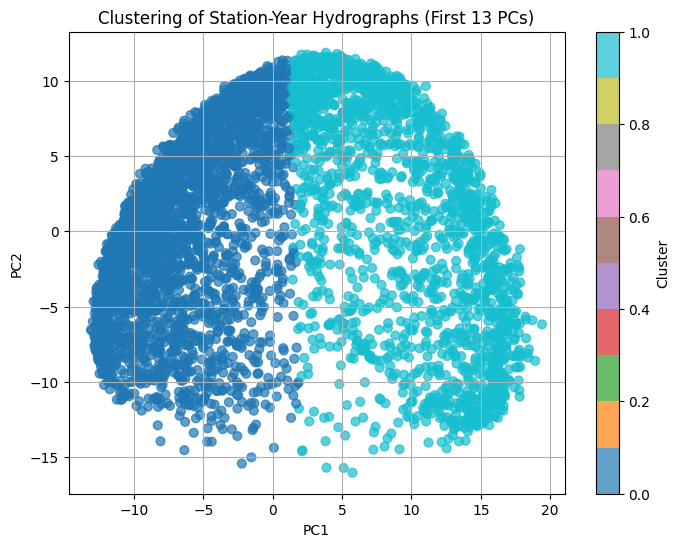

In [6]:
from sklearn.cluster import KMeans

# -------------------------------------------------
# Project data into PCA space
# -------------------------------------------------
X_pca = pca.transform(X_scaled)

# clusters to use
n_clusters = 2

# Choose how many PCs to use
N = num_components
features = X_pca[:, :N]

# -------------------------------------------------
# Cluster
# -------------------------------------------------
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(features)

# -------------------------------------------------
# Plot PC1 vs PC2 colored by cluster
# -------------------------------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", s=40, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clustering of Station-Year Hydrographs (First {N} PCs)")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


In [7]:
from collections import Counter

# clusters: array of cluster labels for each station-year sample
# labels: list of (station, year) tuples corresponding to each row in X_scaled

# Build mapping from station -> majority cluster across years
station_clusters = {}
for st in stations_common:
    # Collect all cluster assignments for this station across years
    st_clusters = [clusters[i] for i, (s, y) in enumerate(labels) if s == st]
    
    if st_clusters:  # skip if station has no samples
        # Majority vote: most common cluster
        majority_cluster = Counter(st_clusters).most_common(1)[0][0]
        station_clusters[st] = majority_cluster
        # # PCA mean
        # mean_coords = X_pca[[i for i,(s,y) in enumerate(labels) if s==st], :N].mean(axis=0)
        # station_clusters[st] = kmeans.predict(mean_coords.reshape(1,-1))[0]


# Assign to meta dataframe
meta["cluster"] = meta.index.map(station_clusters)

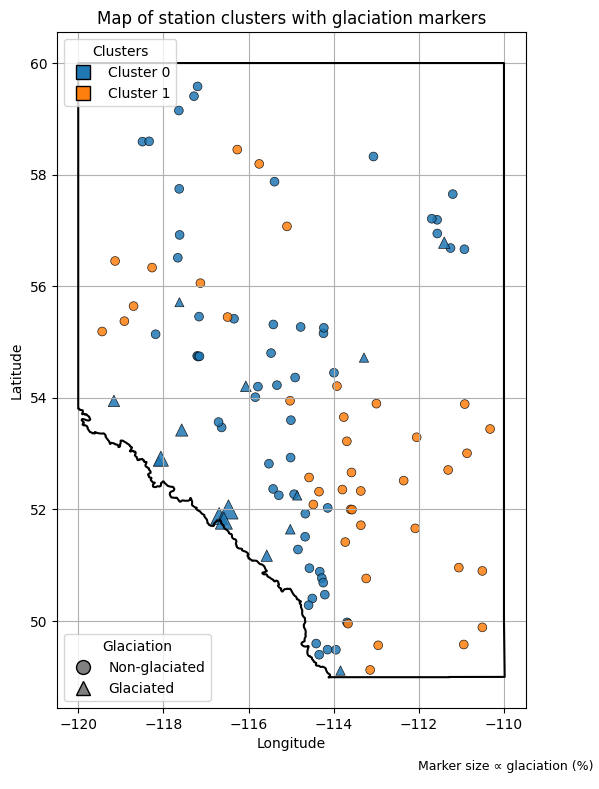

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_hex
from matplotlib.lines import Line2D

# import the alberta boundary
lat_boundary = pd.read_csv("AB_boundary/ABlat.csv", header=None).squeeze("columns")
lon_boundary = pd.read_csv("AB_boundary/ABlon.csv", header=None).squeeze("columns")

# 1) Prepare data and cluster color mapping (categorical)
cluster_vals = np.array(sorted(meta["cluster"].dropna().unique()))
n_clusters_present = len(cluster_vals)

# Choose a palette with enough distinct colors
base_cmap = plt.get_cmap("tab10")
colors = [to_hex(base_cmap(i % base_cmap.N)) for i in range(n_clusters_present)]

# Map cluster -> color
cluster_to_color = {cl: colors[i] for i, cl in enumerate(cluster_vals)}
point_colors = meta["cluster"].map(cluster_to_color)

# 2) Define glaciation shape rule and optional size scaling
is_glaciated = meta["pct_glacia"].fillna(0) > 0.01
sizes = 40 + meta["pct_glacia"].fillna(0).values * 10  # scale by % glaciation
sizes = np.clip(sizes, 40, 200)  # keep sizes reasonable

# 3) Plot grouped to avoid per-point cmap issues
plt.figure(figsize=(6, 8))

# --- Overlay Alberta boundary ---
plt.plot(lon_boundary, lat_boundary, color="black", linewidth=1.5, label="AB Boundary")

# Non-glaciated (circles)
mask_non = ~is_glaciated
plt.scatter(
    meta.loc[mask_non, "lon"],
    meta.loc[mask_non, "lat"],
    s=sizes[mask_non],
    c=point_colors[mask_non],
    marker="o",
    alpha=0.85,
    edgecolor="k",
    linewidths=0.5,
    label="Non-glaciated (≤1%)"
)

# Glaciated (triangles)
mask_glac = is_glaciated
plt.scatter(
    meta.loc[mask_glac, "lon"],
    meta.loc[mask_glac, "lat"],
    s=sizes[mask_glac],
    c=point_colors[mask_glac],
    marker="^",
    alpha=0.85,
    edgecolor="k",
    linewidths=0.5,
    label="Glaciated (>1%)"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of station clusters with glaciation markers")
plt.grid(True)

# 4) Build a categorical legend for clusters actually present
cluster_handles = [
    Line2D([0], [0], marker="s", color="none", markerfacecolor=cluster_to_color[cl],
           markeredgecolor="k", markersize=10, label=f"Cluster {cl}")
    for cl in cluster_vals
]

shape_handles = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Non-glaciated"),
    Line2D([0], [0], marker="^", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Glaciated"),
]

legend1 = plt.legend(handles=cluster_handles, title="Clusters", loc="upper left", frameon=True)
plt.gca().add_artist(legend1)  # keep first legend when adding second
plt.legend(handles=shape_handles, title="Glaciation", loc="lower left", frameon=True)

# Optional label note for size encoding
plt.annotate("Marker size ∝ glaciation (%)", xy=(0.99, 0.02), xycoords="figure fraction",
             ha="right", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


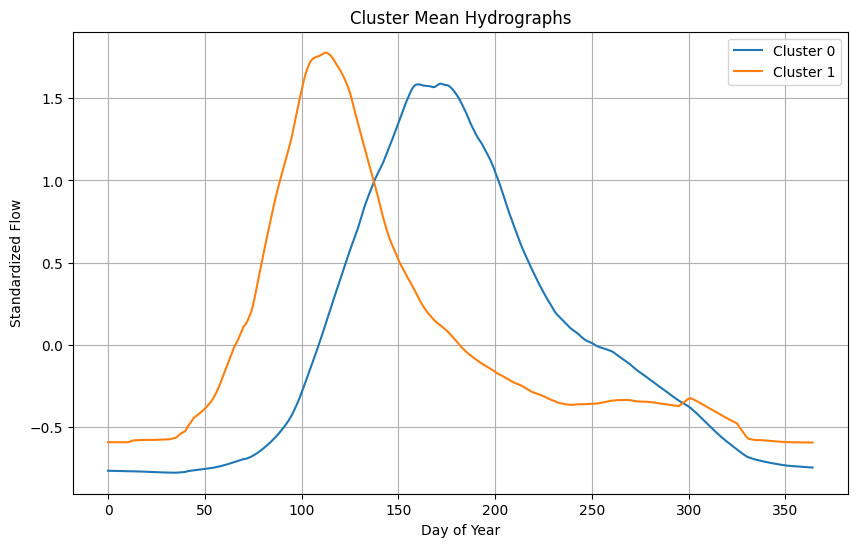

In [10]:
# Compute mean hydrograph for each cluster
unique_clusters = np.unique(clusters)
days_august = np.arange(X_scaled.shape[1])

plt.figure(figsize=(10,6))
for cl in unique_clusters:
    mean_flow = X_scaled[clusters == cl].mean(axis=0)
    plt.plot(days_august, mean_flow, label=f"Cluster {cl}")

plt.xlabel("Day of Year")
plt.ylabel("Standardized Flow")
plt.title("Cluster Mean Hydrographs")
plt.legend()
plt.grid(True)
plt.show()

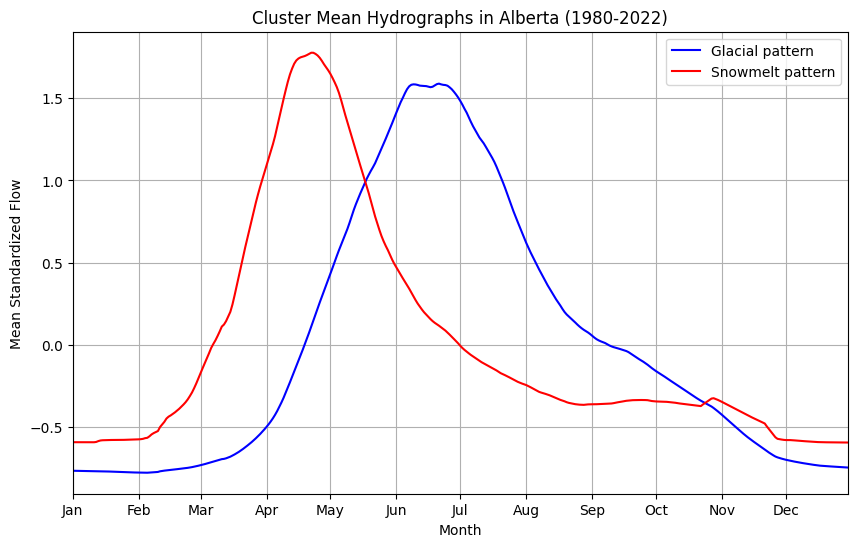

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Compute mean hydrograph for each cluster
unique_clusters = np.unique(clusters)

# name the clusters
cluster_labels = ["Glacial pattern", "Snowmelt pattern"]
colours = ['b', 'r']

# Assume X_scaled has daily values for a full year
n_days = X_scaled.shape[1]
date_range = pd.date_range("2020-01-01", periods=n_days, freq="D")  # dummy year

plt.figure(figsize=(10,6))
for cl in unique_clusters:
    mean_flow = X_scaled[clusters == cl].mean(axis=0)
    plt.plot(date_range, mean_flow, label=cluster_labels[cl], color=colours[cl])

# Format x-axis with month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))

plt.xlabel("Month")
plt.ylabel("Mean Standardized Flow")
plt.title("Cluster Mean Hydrographs in Alberta (1980-2022)")
plt.xlim(date_range[0], date_range[-1])
plt.legend()
plt.grid(True)
plt.show()

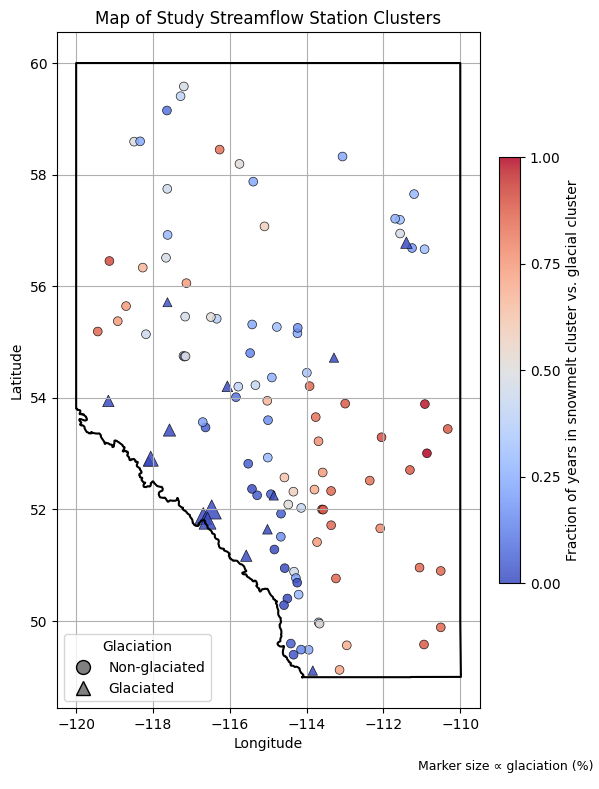

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import pandas as pd

# --- Cluster the data
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(features)

# Build mapping from station -> majority cluster across years
station_clusters = {}
for st in stations_common:
    # Collect all cluster assignments for this station across years
    station_clusters[st] = np.mean([clusters[i] for i, (s, y) in enumerate(labels) if s == st])

# Assign to meta dataframe
meta["cluster"] = meta.index.map(station_clusters)

# --- Import the Alberta boundary ---
lat_boundary = pd.read_csv("AB_boundary/ABlat.csv", header=None).squeeze("columns")
lon_boundary = pd.read_csv("AB_boundary/ABlon.csv", header=None).squeeze("columns")

# Choose a continuous colormap
cmap = plt.get_cmap("coolwarm")

# --- Define glaciation shape rule and optional size scaling ---
is_glaciated = meta["pct_glacia"].fillna(0) > 0.01
sizes = 40 + meta["pct_glacia"].fillna(0).values * 10
sizes = np.clip(sizes, 40, 200)

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

# Alberta boundary
ax.plot(lon_boundary, lat_boundary, color="black", linewidth=1.5, label="AB Boundary")

# Explicit normalization for colormap
norm = mcolors.Normalize(vmin=0, vmax=1)

# Non-glaciated (circles)
mask_non = ~is_glaciated
sc1 = ax.scatter(
    meta.loc[mask_non, "lon"],
    meta.loc[mask_non, "lat"],
    s=sizes[mask_non],
    c=meta.loc[mask_non, "cluster"],
    cmap=cmap,
    norm=norm,
    marker="o",
    alpha=0.85,
    edgecolor="k",
    linewidths=0.5,
    label="Non-glaciated (≤1%)"
)

# Glaciated (triangles)
mask_glac = is_glaciated
sc2 = ax.scatter(
    meta.loc[mask_glac, "lon"],
    meta.loc[mask_glac, "lat"],
    s=sizes[mask_glac],
    c=meta.loc[mask_glac, "cluster"],
    cmap=cmap,
    norm=norm,
    marker="^",
    alpha=0.85,
    edgecolor="k",
    linewidths=0.5,
    label="Glaciated (>1%)"
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Map of Study Streamflow Station Clusters")
ax.grid(True)

# --- Legends ---
# Shape legend
shape_handles = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Non-glaciated"),
    Line2D([0], [0], marker="^", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Glaciated"),
]
ax.legend(handles=shape_handles, title="Glaciation", loc="lower left", frameon=True)

# Colorbar for gradient clusters
cbar = plt.colorbar(sc1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Fraction of years in snowmelt cluster vs. glacial cluster")
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
# cbar.set_ticklabels([f"Cluster {0}", f"Cluster {1}"])

# Optional label note for size encoding
ax.annotate("Marker size ∝ glaciation (%)", xy=(0.99, 0.02), xycoords="figure fraction",
            ha="right", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

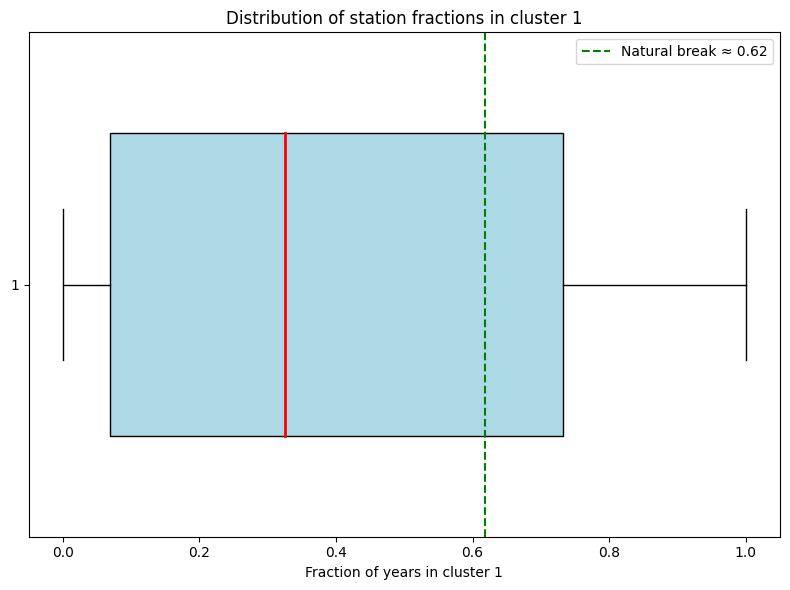

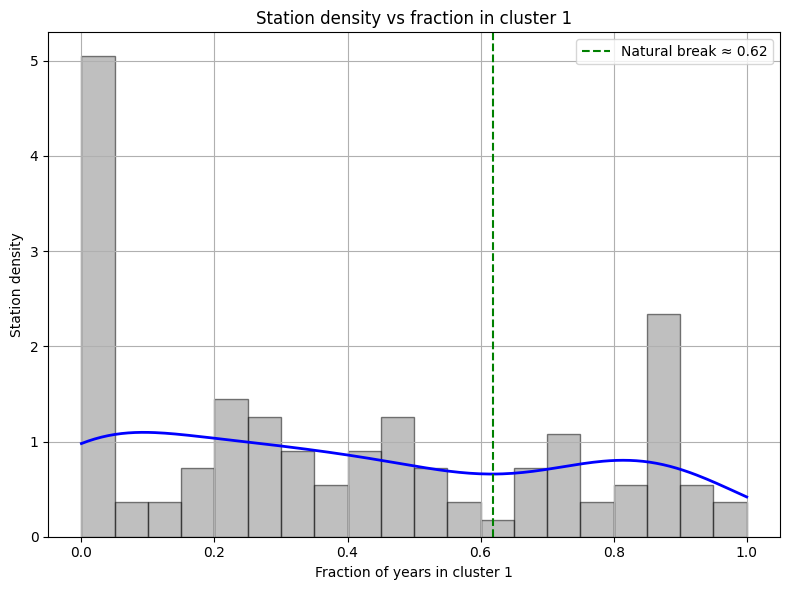

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# meta["cluster"] already contains fraction of years in cluster 1 per station
fractions = meta["cluster"].dropna().values

# --- Box plot ---
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(fractions, vert=False, widths=0.6, patch_artist=True,
           boxprops=dict(facecolor="lightblue", color="k"),
           medianprops=dict(color="red", linewidth=2))

ax.set_xlabel("Fraction of years in cluster 1")
ax.set_title("Distribution of station fractions in cluster 1")

# --- Density estimate to find natural break ---
density = gaussian_kde(fractions)
x_vals = np.linspace(0, 1, 200)
dens_vals = density(x_vals)

# Find local minima in density curve
from scipy.signal import argrelextrema
minima_idx = argrelextrema(dens_vals, np.less)[0]

if len(minima_idx) > 0:
    # Pick the deepest valley as natural break
    break_x = x_vals[minima_idx[np.argmin(dens_vals[minima_idx])]]
    ax.axvline(break_x, color="green", linestyle="--", label=f"Natural break ≈ {break_x:.2f}")
    ax.legend()

plt.tight_layout()
plt.show()

# --- Optional: plot histogram + KDE to visualize density ---
plt.figure(figsize=(8,6))
plt.hist(fractions, bins=20, density=True, alpha=0.5, color="gray", edgecolor="k")
plt.plot(x_vals, dens_vals, color="blue", linewidth=2)
if len(minima_idx) > 0:
    plt.axvline(break_x, color="green", linestyle="--", label=f"Natural break ≈ {break_x:.2f}")
    plt.legend()
plt.xlabel("Fraction of years in cluster 1")
plt.ylabel("Station density")
plt.title("Station density vs fraction in cluster 1")
plt.grid(True)
plt.tight_layout()
plt.show()

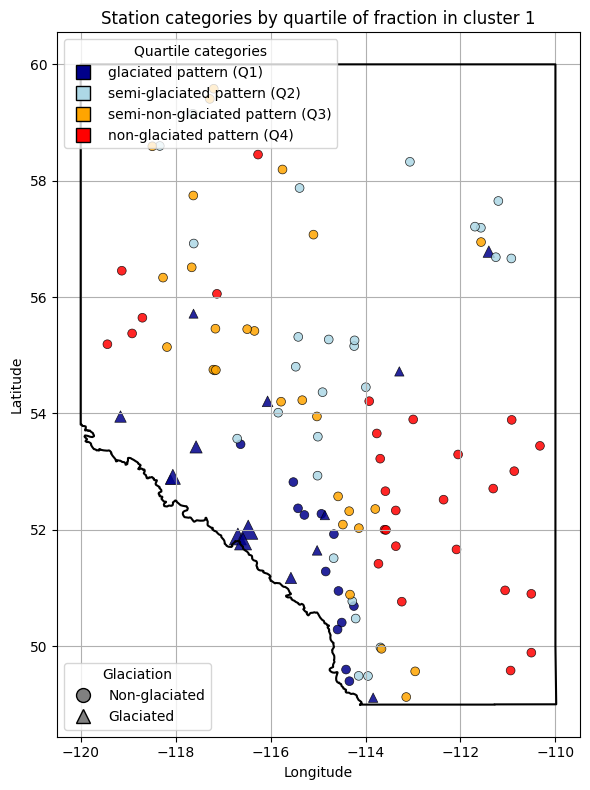

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Fractions of years in cluster 1 ---
fractions = meta["cluster"].dropna()

# --- Compute quartiles ---
q1, q2, q3 = np.percentile(fractions, [25, 50, 75])

# Define bins by quartiles
bins = [fractions.min(), q1, q2, q3, fractions.max()]
labels = [
    "glaciated pattern (Q1)",
    "semi-glaciated pattern (Q2)",
    "semi-non-glaciated pattern (Q3)",
    "non-glaciated pattern (Q4)"
]

meta["pattern_category"] = pd.cut(fractions, bins=bins, labels=labels, include_lowest=True)

# --- Import Alberta boundary ---
lat_boundary = pd.read_csv("AB_boundary/ABlat.csv", header=None).squeeze("columns")
lon_boundary = pd.read_csv("AB_boundary/ABlon.csv", header=None).squeeze("columns")

# --- Map plot with quartile categories ---
fig, ax = plt.subplots(figsize=(6,8))

# Overlay Alberta boundary
ax.plot(lon_boundary, lat_boundary, color="black", linewidth=1.5)

# Assign colors to quartile categories
category_colors = {
    "glaciated pattern (Q1)": "darkblue",
    "semi-glaciated pattern (Q2)": "lightblue",
    "semi-non-glaciated pattern (Q3)": "orange",
    "non-glaciated pattern (Q4)": "red"
}

# Shapes based on glaciation status
is_glaciated = meta["pct_glacia"].fillna(0) > 0.01
sizes = 40 + meta["pct_glacia"].fillna(0).values * 10
sizes = np.clip(sizes, 40, 200)

for cat, color in category_colors.items():
    mask = meta["pattern_category"] == cat
    # Non-glaciated (circles)
    mask_non = mask & (~is_glaciated)
    ax.scatter(meta.loc[mask_non, "lon"], meta.loc[mask_non, "lat"],
               s=sizes[mask_non], c=color, marker="o",
               alpha=0.85, edgecolor="k", linewidths=0.5, label=None)
    # Glaciated (triangles, scaled same way)
    mask_glac = mask & is_glaciated
    ax.scatter(meta.loc[mask_glac, "lon"], meta.loc[mask_glac, "lat"],
               s=sizes[mask_glac], c=color, marker="^",
               alpha=0.85, edgecolor="k", linewidths=0.5, label=None)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Station categories by quartile of fraction in cluster 1")
ax.grid(True)

# Legends: categories + shapes
category_handles = [
    Line2D([0],[0], marker="s", color="none", markerfacecolor=color,
           markeredgecolor="k", markersize=10, label=cat)
    for cat, color in category_colors.items()
]
shape_handles = [
    Line2D([0],[0], marker="o", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Non-glaciated"),
    Line2D([0],[0], marker="^", color="none", markerfacecolor="gray",
           markeredgecolor="k", markersize=10, label="Glaciated"),
]

legend1 = ax.legend(handles=category_handles, title="Quartile categories", loc="upper left", frameon=True)
ax.add_artist(legend1)
ax.legend(handles=shape_handles, title="Glaciation", loc="lower left", frameon=True)

plt.tight_layout()
plt.show()

In [22]:
meta["glaciated"] = meta["pattern_category"] == "glaciated pattern (Q1)"
meta["non-glaciated"] = (meta["pattern_category"] == "non-glaciated pattern (Q4)") | (meta["pattern_category"] == "semi-non-glaciated pattern (Q3)")
meta.rename(columns={"pct_glacia": "pct_glaciation"}, inplace=True)
meta.drop(columns=["cluster"])

# save csv
meta.to_csv("station_cluster_metadata.csv", index_label="StationNum")
meta.head()

,pct_glaciation,Area_km2,lat,lon,cluster,pattern_category,glaciated,non-glaciated
05AA004,0.0,160.55900000000,49.48640,-113.94769,0.232558,semi-glaciated pattern (Q2),False,False
05AA008,0.0,402.93900000000,49.59732,-114.41064,0.046512,glaciated pattern (Q1),True,False
05AA022,0.0,820.56100000000,49.48866,-114.14438,0.139535,semi-glaciated pattern (Q2),False,False
05AA028,0.0,374.21600000000,49.39745,-114.33990,0.023256,glaciated pattern (Q1),True,False
05AB005,0.0,441.55500000000,49.97735,-113.68603,0.325581,semi-glaciated pattern (Q2),False,False
